In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using Zygote, Lux, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib
using Random: Xoshiro
using MLUtils: DataLoader

In [3]:
using PhasorNetworks

# Load the dataset

In [4]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [5]:
using Base: @kwdef

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(data_dir, 1:2)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
q_test, ylocal_test, pt_test = get_samples(data_dir, 3);

In [12]:
q |> size

(20, 13, 21, 99991)

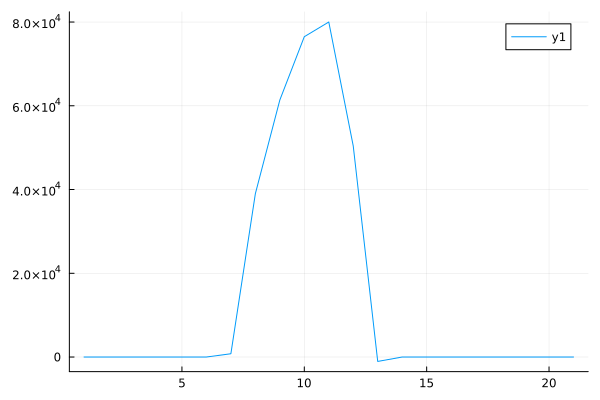

In [13]:
plot(sum(q[:,:,:,128], dims=(1,2)) |> vec)

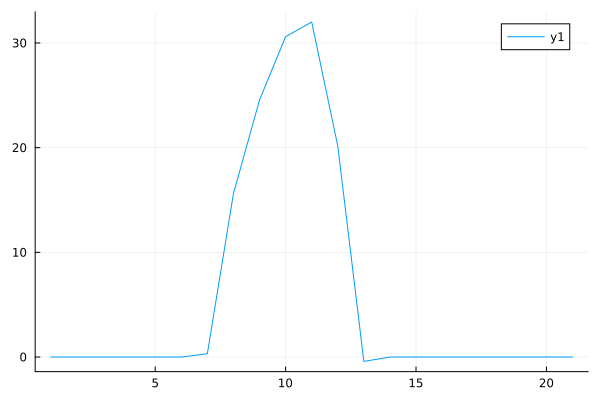

In [14]:
plot(sum(scale_charge(q[:,:,:,128]), dims=(1,2)) |> vec)

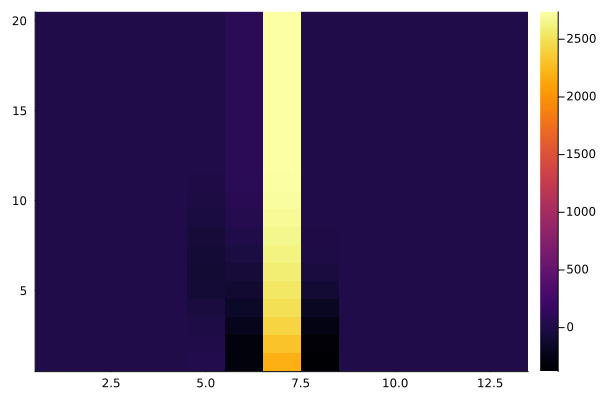

In [15]:
heatmap(q[:,:,12,128])

In [16]:
ylocal |> size

(99991,)

In [17]:
pt |> size

(99991,)

In [18]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [19]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [21]:
x |> size

(20, 13, 21, 128)

In [22]:
n_px = size(x, 1) * size(x,2)
n_in = n_px + 1

261

# Set up the model

In [23]:
function process_inputs(x, y_local)
    x = scale_charge(x)
    x = sum(x, dims=(3))
    n_batch = size(x, 4)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [24]:
process_inputs(x, xl)

261×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  ⋮                                      ⋱  ⋮                  
  0.0       0.0       0.0  

In [26]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(261, affine=true, track_stats=true),  # 522 parameters, plus 523
    layer_2 = WrappedFunction(#30),
    layer_3 = PhasorDense((128, 261)),  # 33_536 parameters
    layer_4 = PhasorDense((3, 128)),    # 387 parameters
)         # Total: 34_445 parameters,
          #        plus 523 states.

In [27]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.09775257 -0.033171576 … -0.025073271 -0.18730494; 0.020251632 0.0070170956 … 0.1004462 -0.07731374; … ; 0.04797584 0.04434996 … 0.08837464 0.024525221; -0.002902955 0.14405486 … 0.083823055 -0.06513499], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0

In [28]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([0.17309917851075832 -0.043805524717206855 … -0.07448849872353704 -0.22076215516387712; 0.5360545898698226 -0.4004355406594396 … 0.07909857803656328 0.13592983471712963; 0.07097131985688569 -0.30644485906061125 … -0.13375501186091784 -0.1833493804982597], (layer_1 = (running_mean = [0.0, 0.0, 0.0, 0.0, 9.375000139698387e-8, 2.181250032503158e-5, 5.437500081025064e-6, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761693921, 0.9000005781685054, 0.9000000079584182, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421  …  0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [29]:
y_naive |> size

(3, 128)

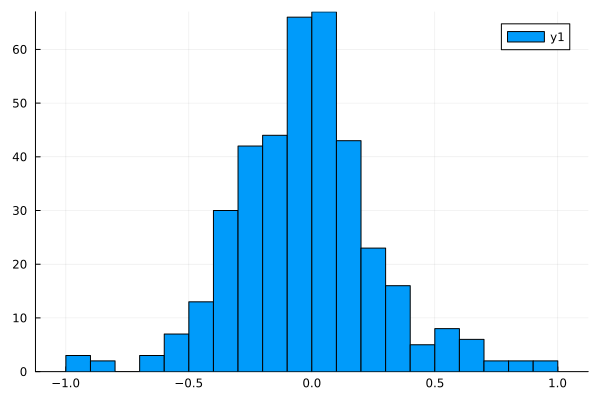

In [30]:
histogram(y_naive |> vec)

In [31]:
using Statistics: std, median, mean

In [32]:
using OneHotArrays

In [33]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [58]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [59]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [60]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [61]:
l0, st0 = @time loss(x, xl, y, model, ps, st, 0.2)

  0.056872 seconds (199.13 k allocations: 22.864 MiB, 95.75% compilation time)


(0.5354288945934624, (layer_1 = (running_mean = [0.0, 0.0, 0.0, 0.0, 9.375000139698387e-8, 2.181250032503158e-5, 5.437500081025064e-6, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761693921, 0.9000005781685054, 0.9000000079584182, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421  …  0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [62]:
l0

0.5354288945934624

In [63]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [64]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 5)

[ Info: Constructing model and starting training


 40.316934 seconds (4.28 M allocations: 179.111 GiB, 22.66% gc time, 2.22% compilation time: 9% of which was recompilation)


(Any[0.21328587695190593, 0.19732362887212876, 0.1872713299389936, 0.18175853834330682, 0.17707659230605147], (layer_1 = (scale = Float32[0.8948443, 0.895473, 1.0110157, 1.0865307, 1.0606158, 0.8945426, 0.94507045, 1.0089812, 0.9164871, 0.88061583  …  0.90516144, 0.9175626, 0.8977282, 0.9509151, 0.9723716, 0.90643114, 0.99501765, 1.0620131, 0.98329586, 0.29890227], bias = Float32[-0.025966458, 0.04007297, -0.042920828, -0.04799646, -0.06549332, 0.03862785, 0.04275041, 0.0393803, -0.02500593, 0.058124192  …  0.037170064, 0.04544591, -0.0153738195, 0.07590948, 0.008194837, 0.06506053, 0.026757108, -0.045258947, -0.05193288, 0.17556116]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.11281379 -0.04234312 … -0.04563849 -0.25984547; 0.017042832 -0.0014109749 … 0.105080634 -0.27090332; … ; 0.06039038 0.046642702 … 0.08354105 -0.41606554; -0.0006794143 0.15265697 … 0.091611534 0.121662214], bias = ComplexF32[0.9941822f0 + 0.058029603f0im, 1.0159535f0 + 0.03586956f0im, 0.9886831f0 - 0

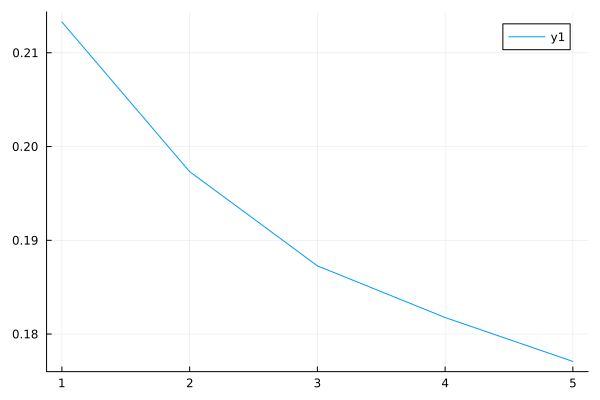

In [65]:
plot(loss_history)

In [66]:
loss(x, xl, y, model, pst, stt, 0.2)[1]

0.18259880204130285

In [67]:
loss_history2, pst2, stt2 = train(model, pst, stt, train_loader, 0.2, epochs = 95)

[ Info: Constructing model and starting training


(Any[0.1738398855360438, 0.17137560301367485, 0.16911920462056448, 0.16673636416910448, 0.16535153239843425, 0.16419998685541412, 0.16286929458334554, 0.16125918620286325, 0.16036427177633458, 0.16010152834363503  …  0.1370960936856905, 0.13702946556764373, 0.13717423013517754, 0.1367576311473143, 0.13634718445056154, 0.1368275957471513, 0.1363684364608069, 0.13623995099470318, 0.13608937911645472, 0.13595395560482934], (layer_1 = (scale = Float32[0.37715894, 0.61448956, 0.9343013, 0.85321736, 0.8582797, 0.652329, 0.47448978, 1.1539708, 0.49005234, 0.5782535  …  0.24241826, 0.9236841, 0.71383107, 0.9411439, 0.74414146, 0.31613415, 0.72879165, 1.1290292, 0.4661063, 0.236052], bias = Float32[0.00201395, 0.12485206, 0.10212685, -0.1520852, -0.047832247, 0.17748334, 0.1290283, 0.10852089, -0.0753766, 0.12649651  …  0.19694662, 0.1400265, 0.0182318, 0.18283054, 0.104422234, 0.19460012, 0.08328907, 0.031958222, -0.047518533, 0.2580704]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0

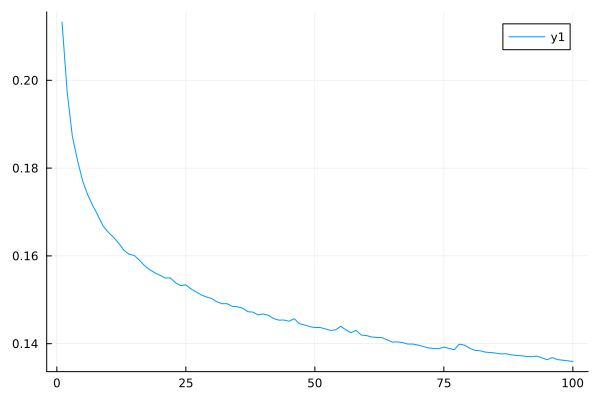

In [68]:
plot(vcat(loss_history, loss_history2))

In [69]:
pst = pst2

(layer_1 = (scale = Float32[0.37715894, 0.61448956, 0.9343013, 0.85321736, 0.8582797, 0.652329, 0.47448978, 1.1539708, 0.49005234, 0.5782535  …  0.24241826, 0.9236841, 0.71383107, 0.9411439, 0.74414146, 0.31613415, 0.72879165, 1.1290292, 0.4661063, 0.236052], bias = Float32[0.00201395, 0.12485206, 0.10212685, -0.1520852, -0.047832247, 0.17748334, 0.1290283, 0.10852089, -0.0753766, 0.12649651  …  0.19694662, 0.1400265, 0.0182318, 0.18283054, 0.104422234, 0.19460012, 0.08328907, 0.031958222, -0.047518533, 0.2580704]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.1454413 -0.062748 … -0.07388234 -0.56758446; 0.07234805 0.022628307 … 0.09858428 -0.16294767; … ; 0.08482282 0.05525497 … 0.08243769 -0.81893057; 0.05142254 0.21416163 … 0.19217536 0.049777288], bias = ComplexF32[0.97812384f0 + 0.25503114f0im, 1.0285904f0 + 0.10806109f0im, 0.97362745f0 - 0.005415319f0im, 0.9851468f0 + 0.057966456f0im, 1.0090609f0 - 0.04889444f0im, 1.0721438f0 + 0.1556238f0im, 1.0083892f0 + 0.24568908f0i

In [70]:
sttf = Lux.testmode(stt2)

(layer_1 = (running_mean = [0.0020049796850573173, 0.0038465411568973963, 0.007008422697695091, 0.011322565465565228, 0.016508610845333494, 0.032287590219250546, 0.03577101086289687, 0.035803196449007285, 0.035871926511827266, 0.03591481180639791  …  0.006348565165674896, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.15291454619067543], running_var = [0.0024285108204652526, 0.005356105787120463, 0.010248544774919826, 0.024135049747417155, 0.04629064750572445, 0.13914586670202947, 0.17765944713707052, 0.1781918087435757, 0.17834256252453168, 0.17842162162531636  …  0.03335061543127993, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = Nam

In [71]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.12602301500864133, (layer_1 = (running_mean = [0.0020049796850573173, 0.0038465411568973963, 0.007008422697695091, 0.011322565465565228, 0.016508610845333494, 0.032287590219250546, 0.03577101086289687, 0.035803196449007285, 0.035871926511827266, 0.03591481180639791  …  0.006348565165674896, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.15291454619067543], running_var = [0.0024285108204652526, 0.005356105787120463, 0.010248544774919826, 0.024135049747417155, 0.04629064750572445, 0.13914586670202947, 0.17765944713707052, 0.1781918087435757, 0.17834256252453168, 0.17842162162531636  …  0.03335061543127993, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 0.03335087394257167, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = Named

In [72]:
loss_history[end]

0.17707659230605147

In [73]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([0.008144410510906638 0.028184072074733245 … 0.02504023051619945 0.02700790530078797; 0.44453167283297257 0.3052200044900307 … 0.00740205917099577 0.1742036237885363; 0.046068783030200476 0.34595183095701293 … 0.4913356594582708 0.34240873554615936], (layer_1 = (running_mean = [0.0018044816687491447, 0.003461886949498969, 0.006307580260831764, 0.010190308649057709, 0.014857843117205588, 0.029080642927854384, 0.03219934642384085, 0.032222875950491836, 0.03228473300539116, 0.03232332976948228  …  0.005713708497745818, 0.005713901663549774, 0.005713901663549774, 0.005713901663549774, 0.005713901663549774, 0.005713901663549774, 0.005713901663549774, 0.005713901663549774, 0.005713901663549774, 0.2094285897770764], running_var = [0.0021856596805185174, 0.004820495080708904, 0.009223690053083496, 0.021721544197251013, 0.041661581662746965, 0.12523187872469385, 0.15989352998790823, 0.16037262362079435, 0.16050830202006047, 0.16057945520888178  …  0.0300155530930113, 0.030015785753167705, 0.03

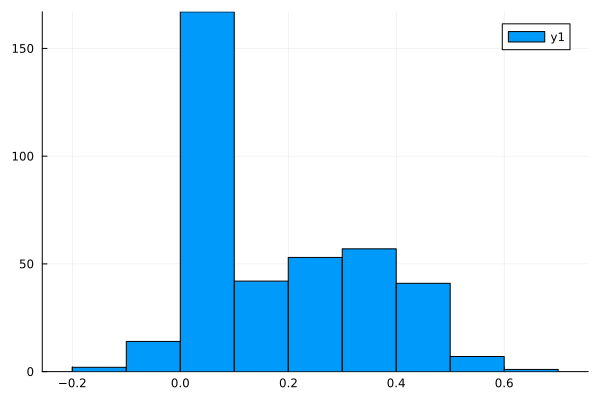

In [74]:
histogram(yt |> vec)

# Calculate the Test Loss

In [75]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [81]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    #predict & correct for zero indexing
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [82]:
yth, _ = model(process_inputs(xts, xlts), pst, sttf)

([0.016070636846571913 0.02277522979851271 … 0.022220097834353438 0.03171656203219861; -0.029871159754174904 -0.0713069544440583 … 0.38737017815162567 0.4058844824867508; 0.4629385348950313 0.5941011324798052 … 0.10683267535060775 0.01670161061520282], (layer_1 = (running_mean = [0.0020049796850573173, 0.0038465411568973963, 0.007008422697695091, 0.011322565465565228, 0.016508610845333494, 0.032287590219250546, 0.03577101086289687, 0.035803196449007285, 0.035871926511827266, 0.03591481180639791  …  0.006348565165674896, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.006348779794351644, 0.15291454619067543], running_var = [0.0024285108204652526, 0.005356105787120463, 0.010248544774919826, 0.024135049747417155, 0.04629064750572445, 0.13914586670202947, 0.17765944713707052, 0.1781918087435757, 0.17834256252453168, 0.17842162162531636  …  0.03335061543127993, 0.03335087394257167, 0.

In [83]:
accuracy(xts, xlts, yts, model, pst, sttf, 0.2)

89

In [84]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [85]:
using LinearAlgebra: diag

In [86]:
roc = tpr_fpr(yth, yts)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [87]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

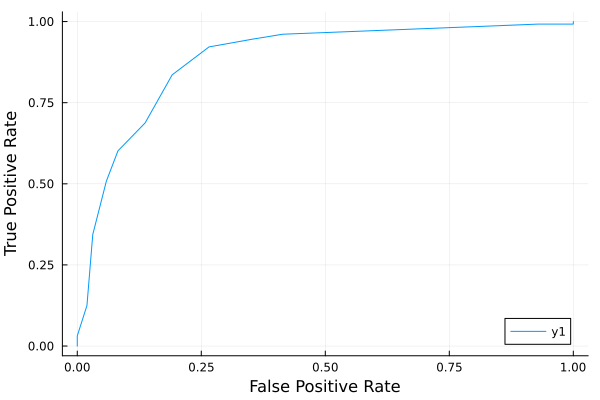

In [88]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [89]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8841552658786277, 3.6176786159846167e-9)